## Imports

In [1]:
%matplotlib inline
# Core
import numpy as np
from PIL import Image
import cv2
from imageio import imwrite
import statistics as stats
import pandas as pd

import numpy as np
import lmfit
from lmfit import Model

# Visualization
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# Settings & Globals
printText = False

kernel = np.ones((3, 3), np.uint8)

## Image Processing

In [3]:
# Showing image
def showImage(img, title1 = "Original"):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img), plt.title(title1)
  plt.show()

In [4]:
# Getting image from path
def getImage(file_path=""):
    if file_path == "":
        file_path = filedialog.askopenfilename(filetypes=[("Image Files", ".png .jpg")])
    img = cv2.imread(file_path)
    
    return img

In [5]:
# To greyscale image
def grayscale(img):
    copy = img.copy()
    copy[:, :, 0] = copy[:, :, 2]  = 0
    gray = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY)
    return gray

In [6]:
#  To truncate image (not needed)
def truncateImage(image,y_front=0,y_back=40,x_front=0,x_back=0,save=False,name=""):
    height,width=image.shape[:2]
    print(image.shape)
    if(len(image.shape)==2):
        image=image[y_front:height-y_back-1,x_front:width-x_back-1]
    else:
        image=image[y_front:height-y_back-1,x_front:width-x_back-1,:]
    if(save):
        if(name==""):
            name="truncated_image.png"
        imwrite(name,image)
    return image

## Setting up image

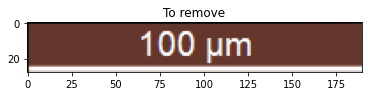

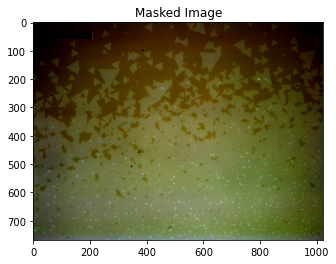

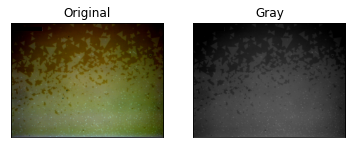

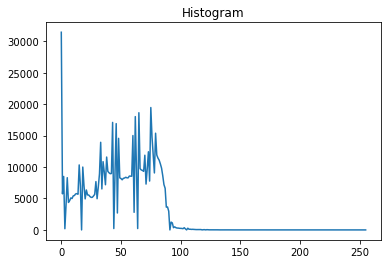

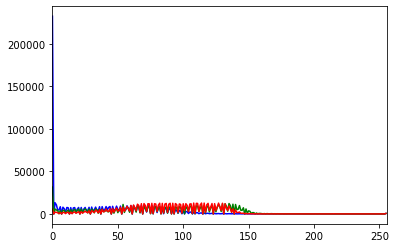

In [7]:
# setting up
img = getImage("img2.png")

# finding area to mask off
showImage(img[32:60,20:210,:], "To remove")

# create mask to remove top left part
mask = np.full(img.shape[:2], 255,np.uint8)
mask[32:60,20:210] = 0
masked_img = cv2.bitwise_and(img,img,mask = mask)
showImage(masked_img, "Masked Image")

gray = grayscale(masked_img)

# showing images
plt.subplot(1,2,1), plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.title("Gray"), plt.xticks([]), plt.yticks([])
plt.show()

# creating histograms of grayscaled image
histMask = cv2.calcHist([gray],[0],mask,[256],[0,256])
plt.title("Histogram")
plt.plot(histMask);plt.show()

color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()


## Visualization

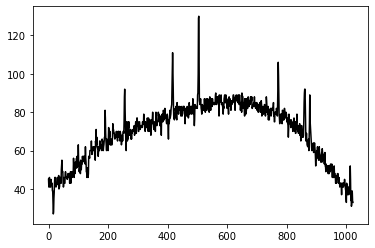

In [8]:
grayLine = gray[650,:]

plt.plot(np.arange(len(grayLine)),grayLine,"k");plt.show()

## Curve Fitting

In [9]:
def gaussian(coordinates, amp ,cenX, cenY, widthX, widthY):
    x = coordinates[:, 0]
    y = coordinates[:, 1]
    return amp * np.exp(-(x-cenX)**2 / (2*widthX**2)-(y-cenY)**2 / (2*widthY**2))

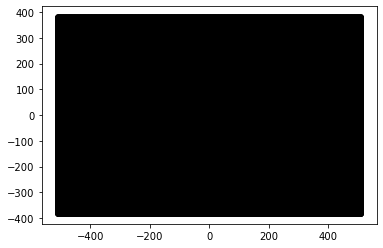

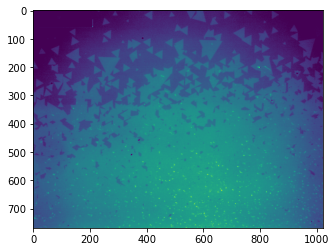

In [10]:
width = len(gray[0])
height = len(gray[:,0])

data = np.empty((width*height,3))

widthArray = np.linspace(-width/2 , width/2, width)
heightArray = np.linspace(-height/2 , height/2, height)

#widthArray = np.arange(len(gray[0]))
#heightArray = np.arange(len(gray[:,0]))

xx, yy = np.meshgrid(widthArray,heightArray)

plt.plot(xx, yy, marker='.', color='k', linestyle='none')
plt.show()

data[:,0] = xx.flatten()
data[:,1] = yy.flatten()
data[:,2] = gray[:,:].flatten()


plt.imshow(data[:, 2].reshape(height,width))

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 786432
    # variables        = 5
    chi-square         = 1.9825e+08
    reduced chi-square = 252.093141
    Akaike info crit   = 4348815.59
    Bayesian info crit = 4348873.47
[[Variables]]
    amp:     65.5459403 +/- 0.04796239 (0.07%) (init = 1)
    cenX:    113.953666 +/- 0.52484130 (0.46%) (init = 0)
    cenY:    298.598637 +/- 1.46963139 (0.49%) (init = 10)
    widthX:  559.781549 +/- 0.33870653 (0.06%) (init = 10)
    widthY:  527.817464 +/- 1.41408054 (0.27%) (init = 100)
[[Correlations]] (unreported correlations are < 0.600)
    C(cenY, widthY) =  0.930
{'amp': 65.54594033411236, 'cenX': 113.95366634922948, 'cenY': 298.59863685018104, 'widthX': 559.7815485953103, 'widthY': 527.8174636596033}


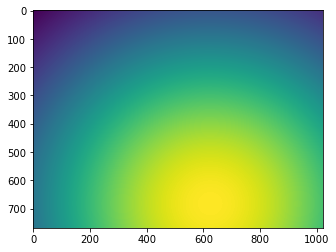

In [18]:
defaultAmp = 1
defaultCenX = 0
defaultCenY = 10
defaultWidthX = 10
defaultWidthY = 100

model = Model(gaussian)

model.set_param_hint('amp', value=1, min=0, max=100)
model.set_param_hint('cenX', value=defaultCenX, min=defaultCenX-width/2, max=defaultCenX+width/2)
model.set_param_hint('cenY', value=defaultCenY, min=defaultCenY -height/2, max=defaultCenY+height/2)
model.set_param_hint('widthX', value=defaultWidthX, min=10, max=600)
model.set_param_hint('widthY', value=defaultWidthY, min=10, max=600)
params = model.make_params()
result = model.fit(data[:, 2], coordinates=data[:, 0:2], params=params)
print(result.fit_report(min_correl=0.60))
print(result.best_values)
plt.imshow(result.best_fit.reshape(height,width))

## Thresholding

In [12]:
# Open and Close morph
def morph(img, openIter = 3, closeIter = 3):
    clean = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=openIter)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=closeIter)
    return clean

In [13]:
def adaptiveThresholding(img, blockSize=505, C=-2):
    gray = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C
    )  ########## 2 magic numbers here
    plt.subplot(1,3,1),plt.imshow(img,'gray')
    plt.title('Original Noisy Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.hist(img.ravel(),256)
    plt.title('Histogram'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(gray,'gray')
    plt.title("OpenCV Adaptive Thresholding"), plt.xticks([]), plt.yticks([])   
    
    plt.show()
    return gray

In [14]:
def otsuThresholding(img):
    ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    plt.subplot(2,3,1),plt.imshow(img,'gray')
    plt.title('Original Noisy Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,2),plt.hist(img.ravel(),256)
    plt.title('Histogram'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,3),plt.imshow(th2,'gray')
    plt.title("Otsu's Thresholding"), plt.xticks([]), plt.yticks([])   
    
    plt.subplot(2,3,4),plt.imshow(blur,'gray')
    plt.title('Gaussian filtered Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,5),plt.hist(blur.ravel(),256)
    plt.title('Histogram'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,6),plt.imshow(th3,'gray')
    plt.title("Otsu's Thresholding"), plt.xticks([]), plt.yticks([])   

    plt.show()
    return th3

In [15]:
def truncate_image(image,y_front=0,y_back=40,x_front=0,x_back=0,save=False,name=""):
    height,width=image.shape[:2]
    print(image.shape)
    if(len(image.shape)==2):
        image=image[y_front:height-y_back-1,x_front:width-x_back-1]
    else:
        image=image[y_front:height-y_back-1,x_front:width-x_back-1,:]
    if(save):
        if(name==""):
            name="truncated_image.png"
        imwrite(name,image)
    return image

In [16]:
def splitOtsu(img, splitNo, kernel):
    blur = cv2.GaussianBlur(img,kernel,0)
    height,width=img.shape[:2]
    
    for heightIndex in range(splitNo):
        for widthIndex in range(splitNo):
            heightFactor = height//splitNo
            startSplitHeight = heightIndex*heightFactor
            endSplitHeight = (heightIndex+1)*heightFactor
            
            widthFactor = width//splitNo
            startSplitWidth = widthIndex*widthFactor
            endSplitWidth = (widthIndex+1)*widthFactor
            
            ret3,th3 = cv2.threshold(blur[startSplitHeight:endSplitHeight,startSplitWidth:endSplitWidth],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            blur[startSplitHeight:endSplitHeight,startSplitWidth:endSplitWidth]=th3 
             
    plt.subplot(1,5,1),plt.imshow(img,'gray')
    plt.title('Original Noisy Image'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(1,5,2),plt.hist(img.ravel(),256)
    plt.title('Histogram'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(1,5,3),plt.imshow(th3,'gray')
    plt.title('Piece'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(1,5,5),plt.imshow(blur,'gray')
    plt.title("Split Otsu Thresholding"), plt.xticks([]), plt.yticks([])
    
    plt.show()
    
    return blur

(768, 1024)


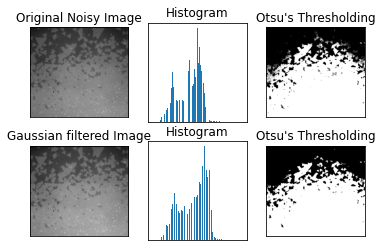

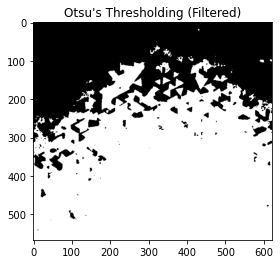

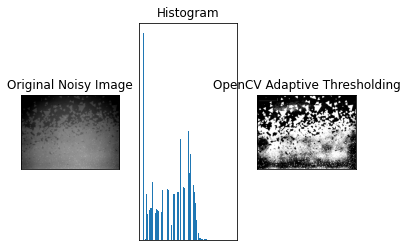

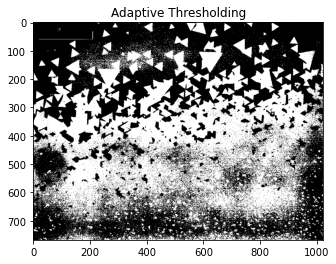

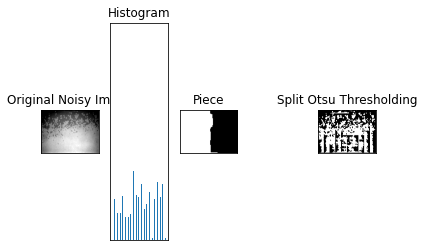

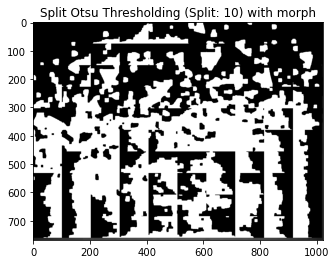

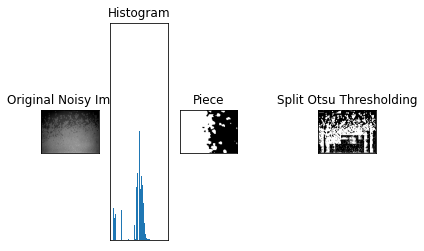

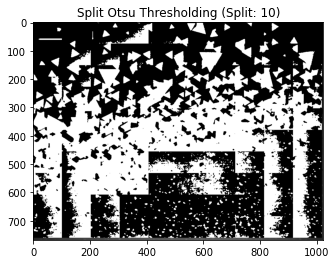

In [17]:
showImage(otsuThresholding(truncate_image(gray,100,100,200,200)),"Otsu's Thresholding (Filtered)")
showImage(adaptiveThresholding(gray, blockSize=505, C=0), "Adaptive Thresholding")

split = 10
plt.imshow(cv2.cvtColor(splitOtsu(morph(gray,5,3),split,(5,5)), cv2.COLOR_BGR2RGB)), plt.title("Split Otsu Thresholding (Split: " + str(split) + ") with morph")
plt.show()

plt.imshow(cv2.cvtColor(splitOtsu(gray,split,(5,5)), cv2.COLOR_BGR2RGB)), plt.title("Split Otsu Thresholding (Split: " + str(split) + ")")
plt.show()

## Curve Fitting